# Offline rule different training times

In [4]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

np.set_printoptions(suppress=True, precision=3)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history
from connectivity_functions import artificial_connectivity_matrix

from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation


In [5]:
epsilon = 10e-20

## An example

In [6]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
# tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 15
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'a', 'z_pre_ampa', 'w_ampa', 'p_pre_ampa', 'p_co_ampa']

inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 3

# Scale
loc = 0.300
scale_percentage = 250.0
scale = loc * scale_percentage / 100.0

# Build the network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
training_time = np.linspace(0.100, 1.500, num=n_patterns)
training_time = [0.100 for i in range(n_patterns)]
training_time[5] = 0.650

#training_time = np.random.normal(loc=loc, scale=scale, size=n_patterns)
#training_time[training_time <= tau_m] = tau_m

# training_time = 0.020
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(network_representation, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)


S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

nn.w_ampa = w_timed
print(training_time)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.65, 0.1, 0.1, 0.1, 0.1]


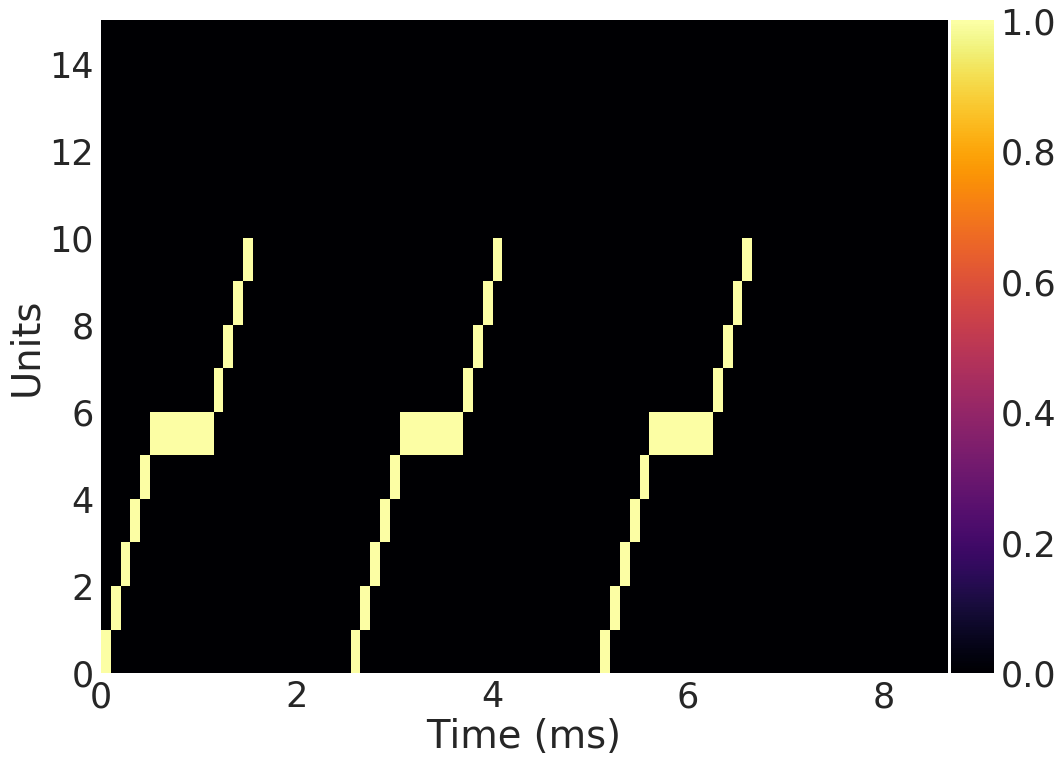

In [7]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

op -> os -> on
3  -> 4 -> 5
0.100 -> 0.100 -> 0.500
w43 > w54

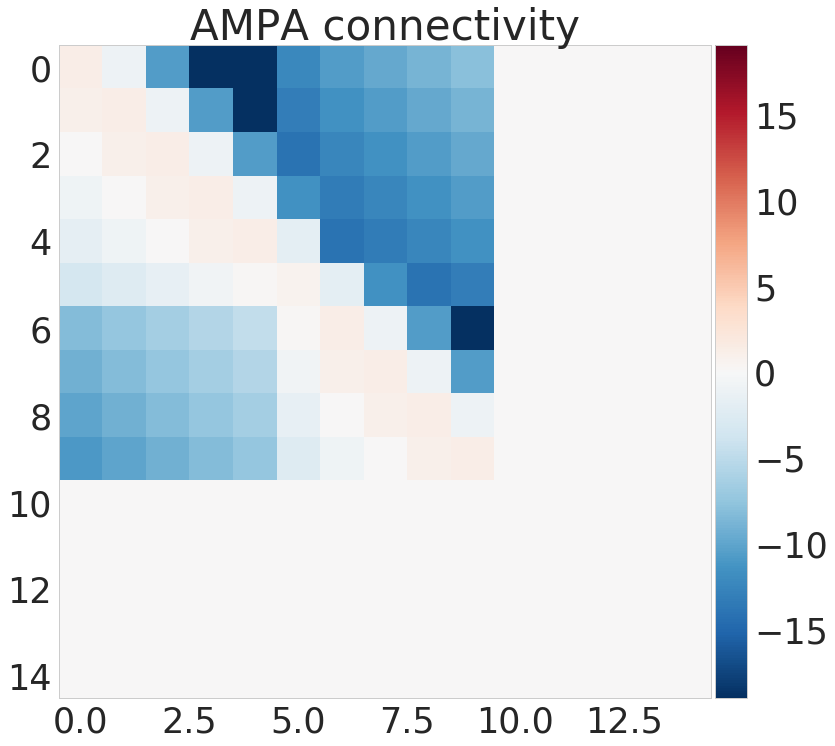

In [8]:
plot_weight_matrix(manager.nn, ampa=True)

0.0


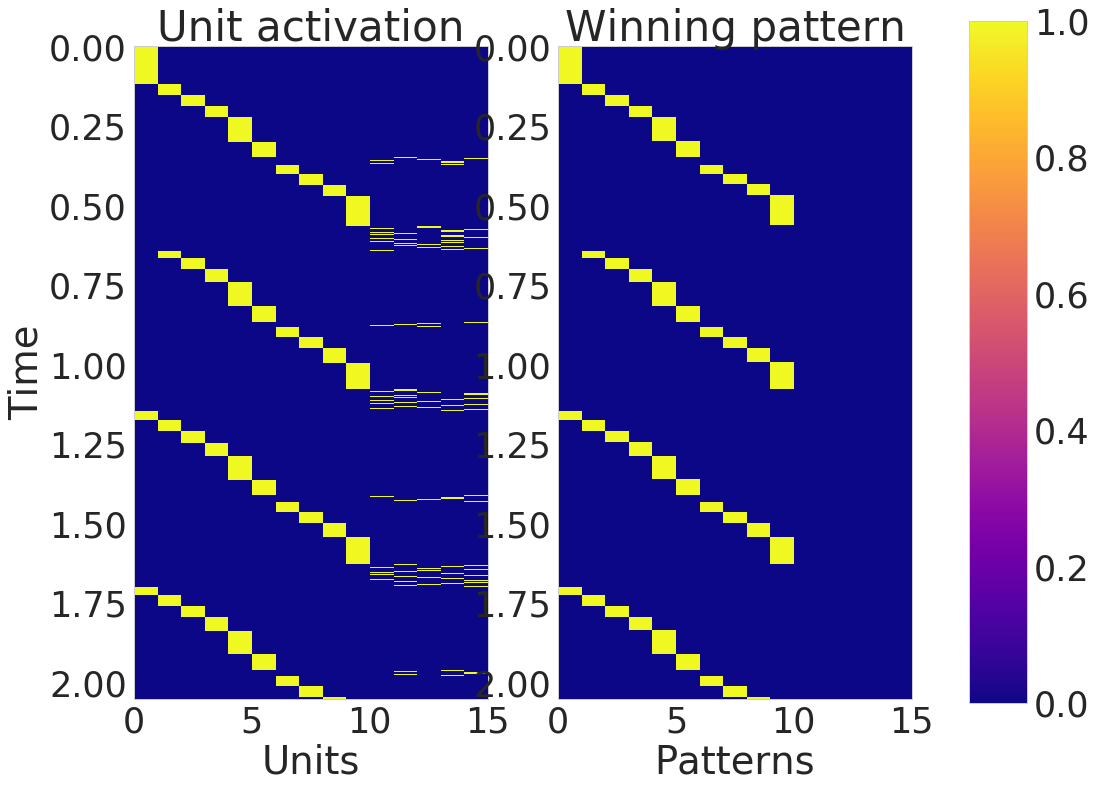

In [9]:
T_recall = 2.0
T_cue = 0.050
sequences = [patterns_indexes]
I_cue = 0.0
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux
plot_network_activity_angle(manager)
print(success)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.65, 0.1, 0.1, 0.1, 0.1]


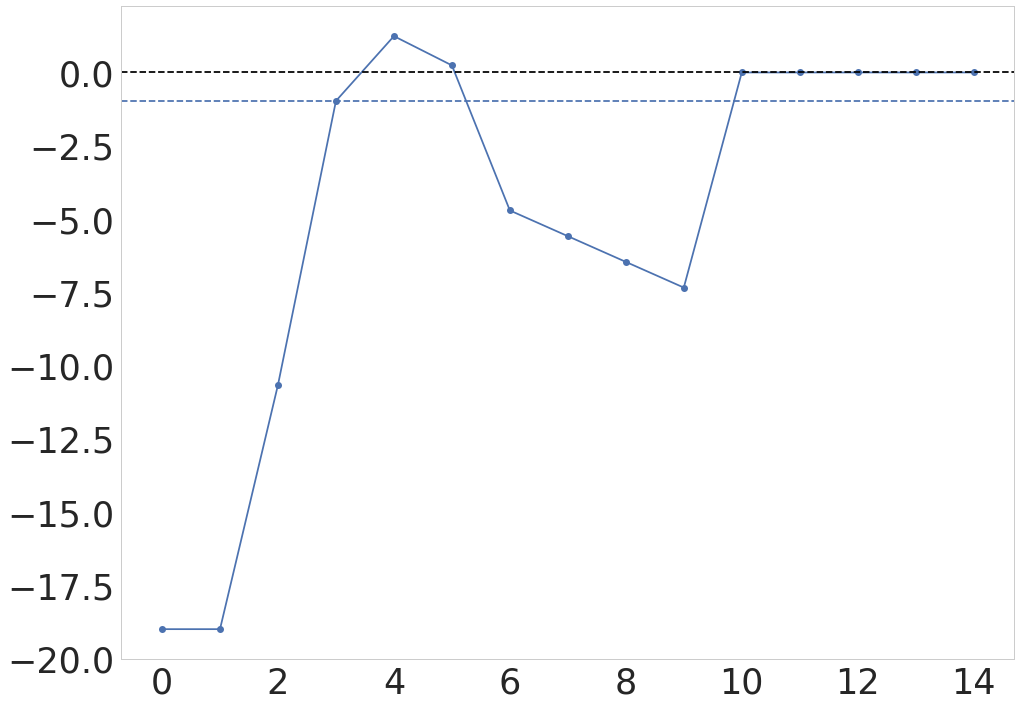

In [10]:
print(training_time)

lost = 4
lost_to = 3

plt.plot(nn.w_ampa[:, lost], 'o-')
plt.axhline(nn.w_ampa[lost_to, lost], ls='--')
plt.axhline(0, ls='--', color='black');

[0.1, 0.1, 0.1, 0.1, 0.1, 0.65, 0.1, 0.1, 0.1, 0.1]


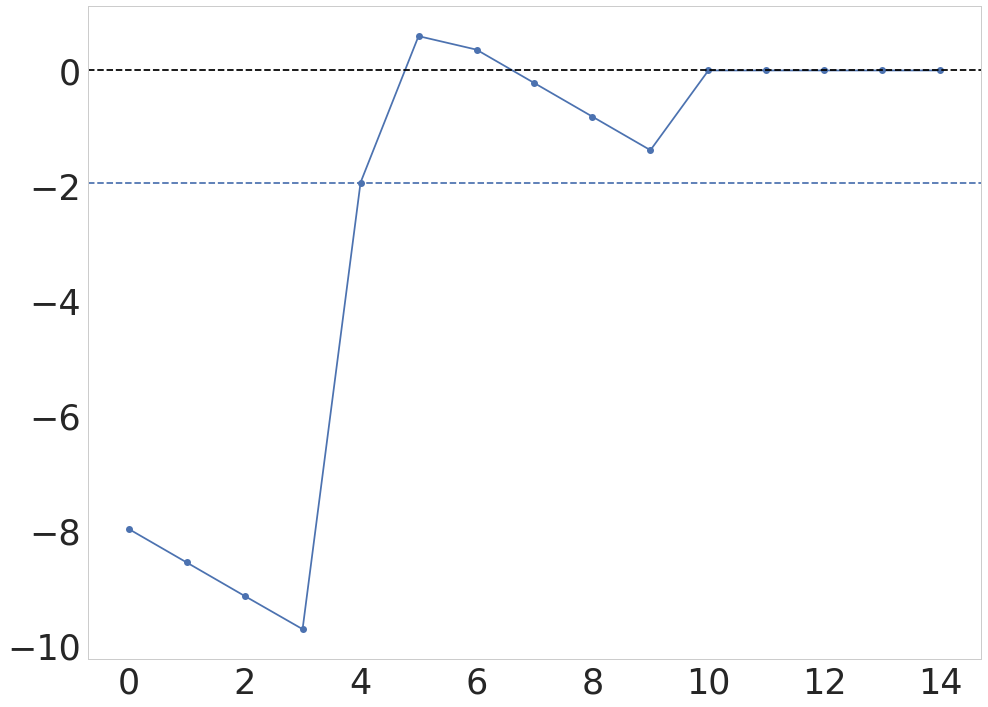

In [329]:
print(training_time)

lost = 5
lost_to = 4

plt.plot(nn.w_ampa[:, lost], 'o-')
plt.axhline(nn.w_ampa[lost_to, lost], ls='--')
plt.axhline(0, ls='--', color='black');

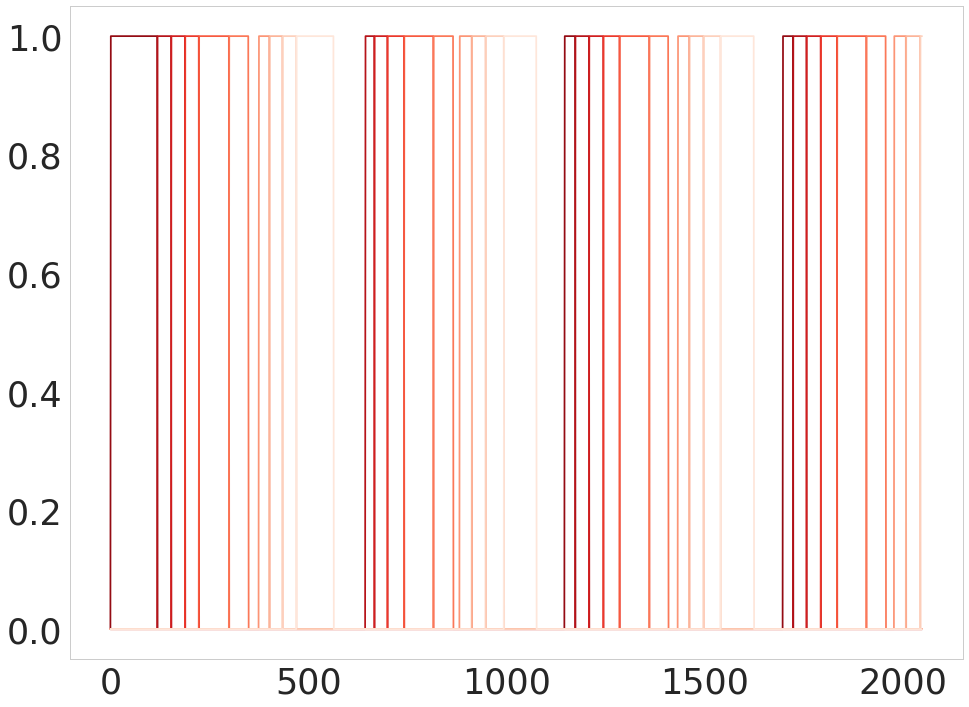

In [320]:
cmap = sns.color_palette("Reds_r", n_colors=n_patterns)
o = manager.history['o']
for pattern in patterns_indexes:
    plt.plot(o[:, pattern], color=cmap[pattern])

## Systematic I 
Here I will test how the weights between an element and its next vary with a step change in training time

In [295]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 15
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 3

weights = []
successes = []
pt = []
base = 0.100
steps = np.linspace(0.100, 1.00, num=10)

for step in steps:
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    training_time = [base for i in range(n_patterns)]
    training_time[5] = step

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)


    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

    nn.w_ampa = w_timed

    weights.append(w_timed)
    
    T_recall = 2.0
    T_cue = 0.050
    sequences = [patterns_indexes]
    I_cue = 0.0
    n = 1

    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    successes.append(success)
    pt.append(mean)
    print(mean)
    

0.066
0.069
0
0
0
0
0
0
0
0
CPU times: user 7.26 s, sys: 16 ms, total: 7.27 s
Wall time: 7.3 s


(-2.0, 2.0)

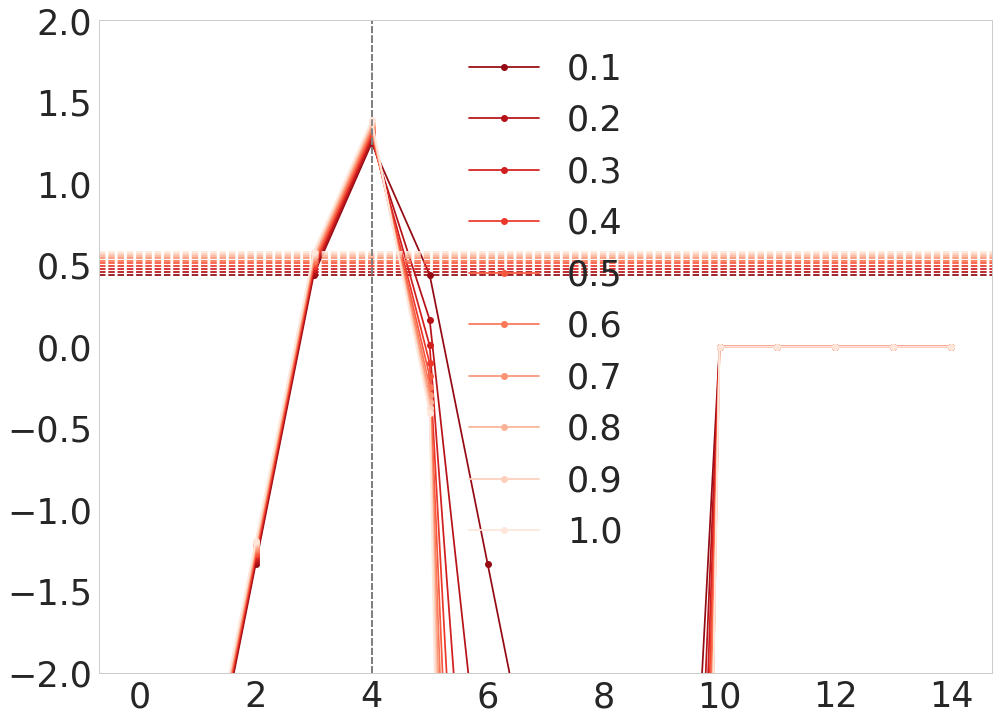

In [296]:
cmap = sns.color_palette("Reds_r", n_colors=steps.size)

lost = 4
lost_to = 3

for index, w in enumerate(weights):
    if True:
        plt.plot(w[:, lost], 'o-', color=cmap[index], label=str(steps[index]))
        plt.axhline(w[lost_to, lost], ls='--', color=cmap[index])
        plt.axvline(lost, ls='--', color='gray')
    
plt.legend();
plt.ylim([-2.0, 2.0])

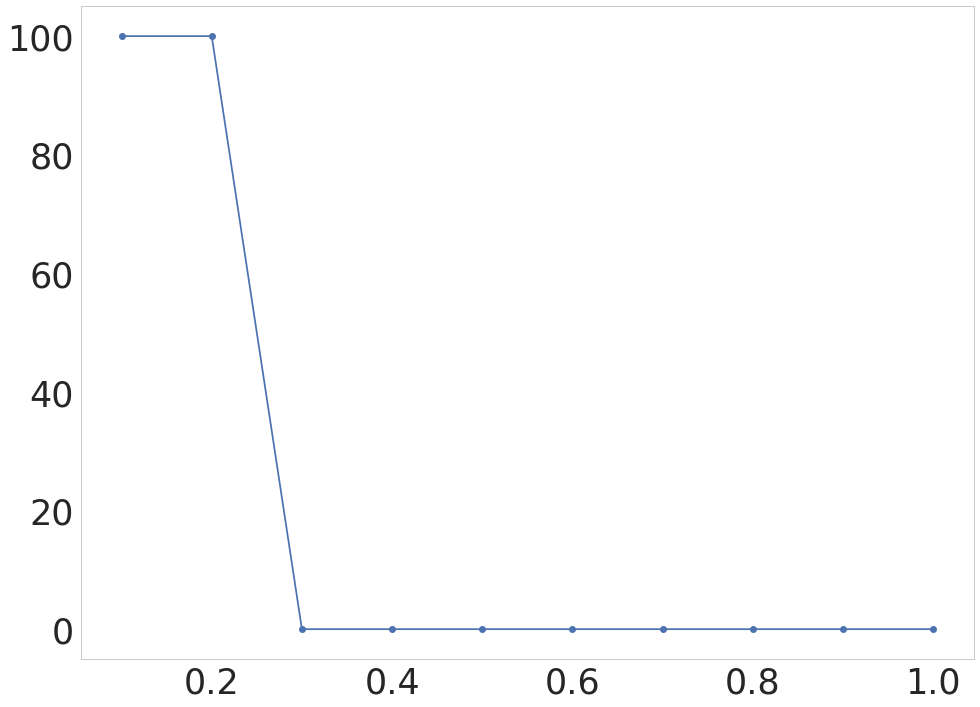

In [297]:
plt.plot(steps, successes, 'o-')

(0.0, 1.0)

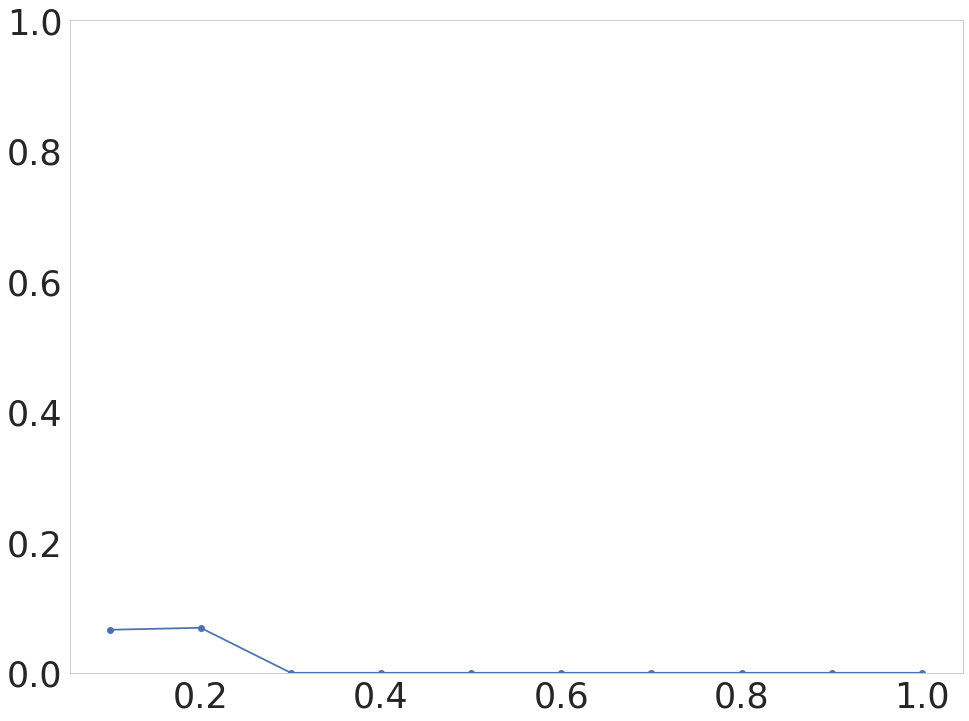

In [298]:
plt.plot(steps, pt, 'o-')
plt.ylim([0.0, 1.0])

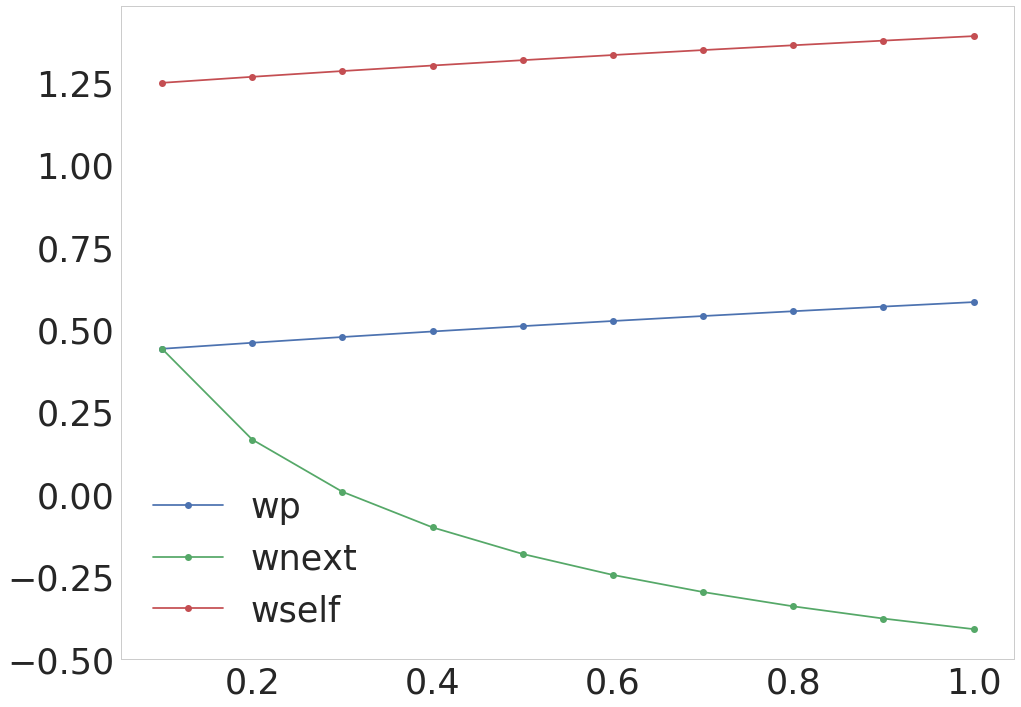

In [299]:
lost = 4
lost_to = 3
w_prev = [w[lost_to, lost] for w in weights]
w_self = [w[lost, lost] for w in weights]
w_next = [w[lost + 1, lost] for w in weights]

plt.plot(steps, w_prev, 'o-', label='wp')
plt.plot(steps, w_next, 'o-', label='wnext')
plt.plot(steps, w_self, 'o-', label='wself')

plt.legend();

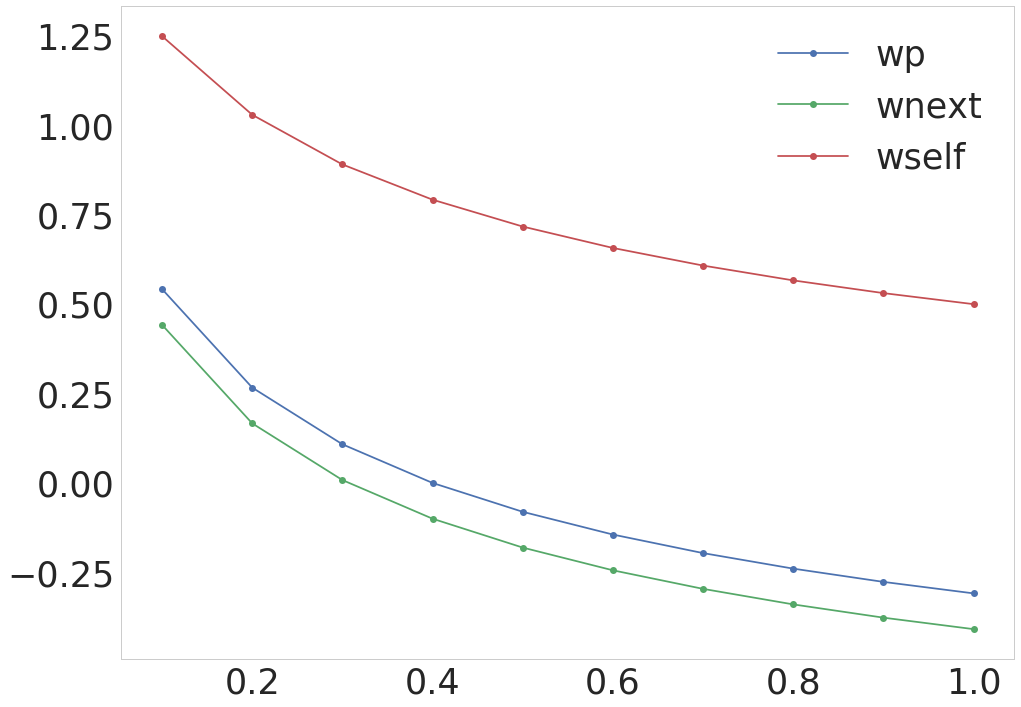

In [302]:
lost = 5
lost_to = 4

w_prev = [w[lost_to, lost] + 0.1 for w in weights]
w_self = [w[lost, lost] for w in weights]
w_next = [w[lost + 1, lost] for w in weights]

plt.plot(steps, w_prev, 'o-', label='wp')
plt.plot(steps, w_next, 'o-', label='wnext')
plt.plot(steps, w_self, 'o-', label='wself')

plt.legend();

## Systematic variable training times

In [264]:
%%time

markersize = 32
linewidth = 10
figsize = (16, 12)

num = 15
trials = 5
failure_treshold = 0.5

############
# General parameters
############
always_learning = False
k_perfect = True
perfect = False
strict_maximum = True
z_transfer = False
diagonal_zero = False
normalized_currents = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.005
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 15
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

###################################################################
# Single protocol
###################################################################

# Recall
T_recall = 4.0
T_cue = 0.100
I_cue = 0.0
n = 1
loc = 0.300
min_scale_percentage = 0
max_scale_percentage = 250.0

min_scale = loc * (min_scale_percentage / 100.0)
max_scale = loc * (max_scale_percentage / 100.0)

scale_vector = np.linspace(min_scale, max_scale, num=num)
success_vector_scale = np.zeros((num, trials))
persistence_time_vector_scale = np.zeros((num, trials))
training_times = np.zeros((num, trials, n_patterns))

for index, scale in enumerate(scale_vector):
    for trial_index in range(trials):
        # Build the network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)
        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # Build the protocol for training
        protocol = Protocol()
        patterns_indexes = [i for i in range(n_patterns)]
        training_time = np.random.normal(loc=loc, scale=scale, size=n_patterns)
        training_time[training_time <= tau_m] = tau_m
       
    
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
        network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

        timed_input = TimedInput(network_representation, dt, training_time, 
                                 inter_pulse_interval=inter_pulse_interval, 
                                 inter_sequence_interval=inter_sequence_interval, 
                                 epochs=epochs, resting_time=resting_time)

        S = timed_input.build_timed_input()
        z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
        z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

        pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
        w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

        nn.w_ampa = w_timed

        sequences = [patterns_indexes]

        aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
        total_sequence_time, mean, std, success, timings = aux

        success_vector_scale[index, trial_index] = success
        persistence_time_vector_scale[index, trial_index] = mean
        training_times[index, trial_index, :] = training_time

CPU times: user 1min 33s, sys: 168 ms, total: 1min 34s
Wall time: 1min 33s


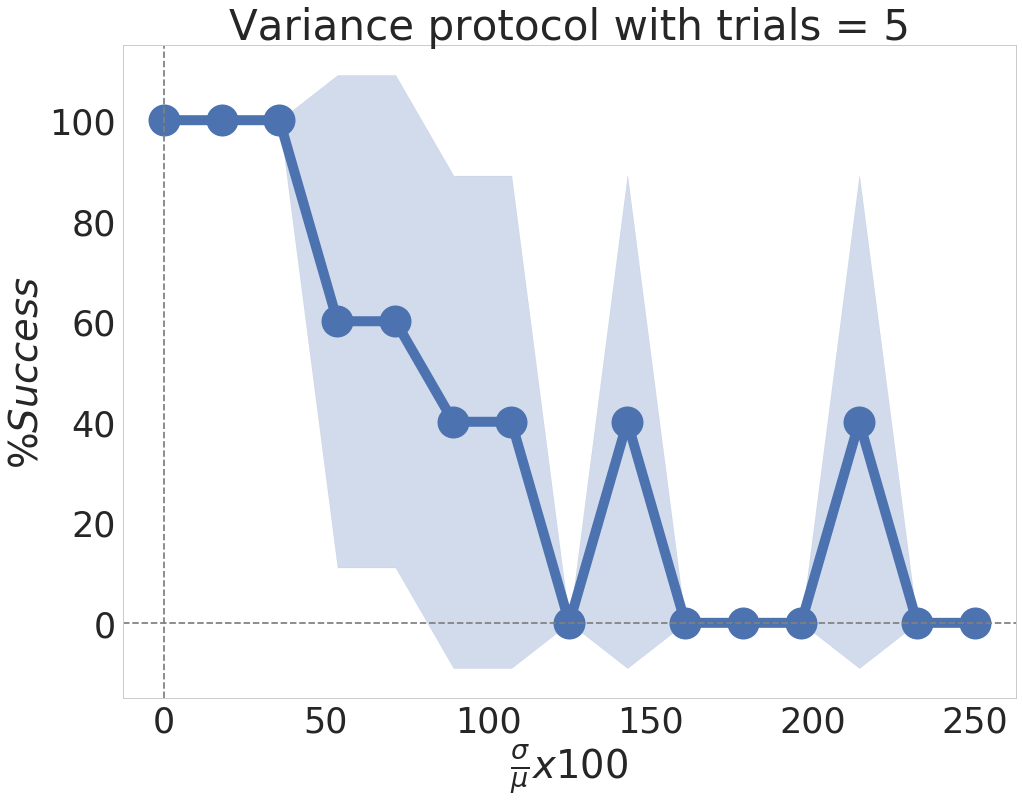

In [265]:
current_palette = sns.color_palette()
index = 0

mean = success_vector_scale.mean(axis=1)
std = success_vector_scale.std(axis=1)

fig1 = plt.figure(figsize=figsize)
ax = fig1.add_subplot(111)
normalized_scale = 100 * scale_vector / loc
ax.plot(normalized_scale, mean, 'o-', color=current_palette[index], markersize=markersize, linewidth=linewidth,
        label='success')
ax.fill_between(normalized_scale, mean - std, mean + std, color=current_palette[index], alpha=0.25)

ax.set_xlabel(r'$\frac{\sigma}{\mu} x 100$')
ax.set_ylabel(r'$\% Success$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.set_title('Variance protocol with trials = ' + str(trials))

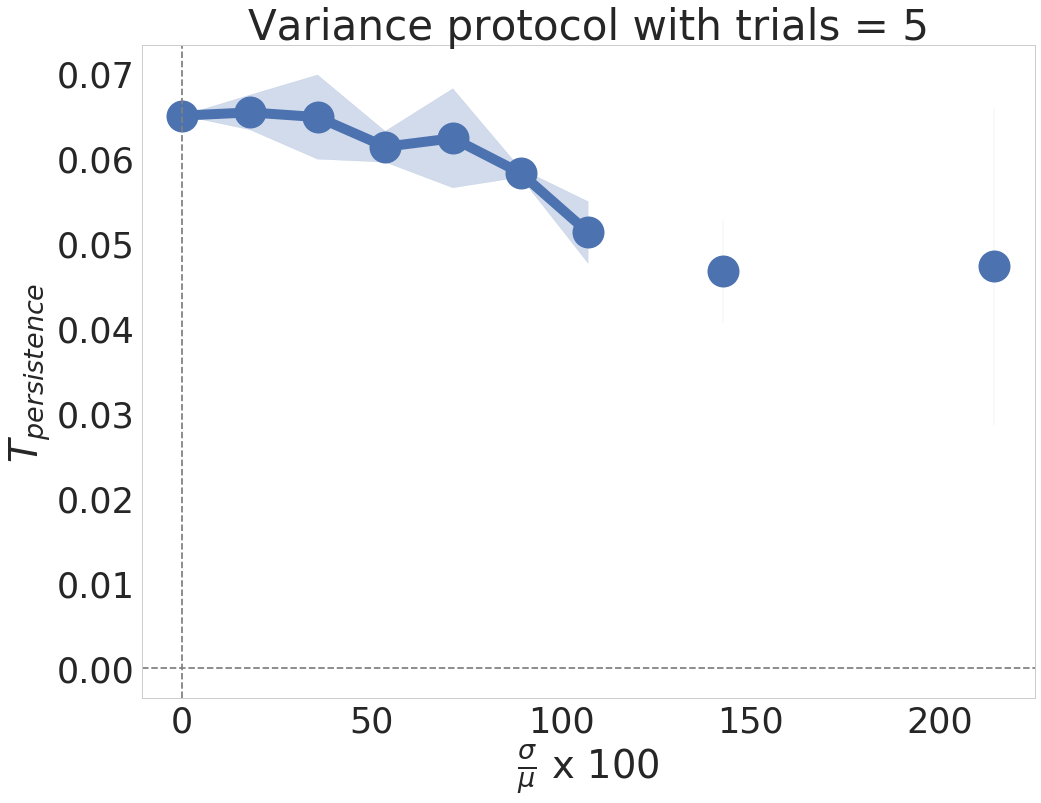

In [266]:
persistence_masked = np.ma.masked_less_equal(persistence_time_vector_scale, 0.0)
persistence = persistence_masked.mean(axis=1)
p_std = persistence_masked.std(axis=1)

fig2 = plt.figure(figsize=(16, 12))
ax2 = fig2.add_subplot(111)
ax2.plot(normalized_scale, persistence, 'o-', markersize=markersize, linewidth=linewidth)
ax2.fill_between(normalized_scale, persistence - p_std, persistence + p_std,
                 color=current_palette[index], alpha=0.25)

ax2.set_xlabel(r'$\frac{\sigma}{\mu}$ x 100')
ax2.set_ylabel(r'$T_{persistence}$')

ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray')
ax2.set_title('Variance protocol with trials = ' + str(trials))



In [204]:
training_times

array([[[ 0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
          0.3  ,  0.3  ],
        [ 0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
          0.3  ,  0.3  ],
        [ 0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
          0.3  ,  0.3  ],
        [ 0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
          0.3  ,  0.3  ],
        [ 0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,  0.3  ,
          0.3  ,  0.3  ]],

       [[ 0.327,  0.347,  0.283,  0.307,  0.297,  0.385,  0.285,  0.3  ,
          0.311,  0.295],
        [ 0.323,  0.259,  0.228,  0.351,  0.32 ,  0.312,  0.309,  0.273,
          0.385,  0.334],
        [ 0.308,  0.245,  0.248,  0.25 ,  0.282,  0.35 ,  0.313,  0.339,
          0.301,  0.196],
        [ 0.313,  0.209,  0.312,  0.311,  0.244,  0.274,  0.336,  0.442,
          0.277,  0.231],
        [ 0.382,  0.291,  0.385,  0.34 ,  0.283,  0.228,  0.277,  0.225,
          0.264,  0.353]],

      